# 1. Introdução
------
Este notebook tem por objetivo demonstrar alguns casos de base em matrizes maiores. Para verificar os casos de base com matrizes fundamentais, veja o notebook [aqui](https://github.com/rsautter/GPA/tree/master/Examples/FundamentalMatrix.ipynb).

Neste notebook é apresentado a função de [densidade de probabilidade da distribuição normal](https://pt.wikipedia.org/wiki/Distribui%C3%A7%C3%A3o_normal) e a função de [Bessel](https://pt.wikipedia.org/wiki/Fun%C3%A7%C3%A3o_de_Bessel) para os casos de padrões simétricos. Também é apresentado os [ruídos coloridos](http://adsabs.harvard.edu/pdf/1995A%26A...300..707T) e o [ruído de Perlin](https://en.wikipedia.org/wiki/Perlin_noise).



Rode a célula a seguir, caso esteja utilizando o colab. As células a seguir instalam as bibliotecas GPA, ruído colorido e ruído de Perlin. 

In [1]:
!pip install git+https://github.com/rsautter/GPA@V4

  Cloning https://github.com/rsautter/GPA (to revision V4) to /tmp/pip-req-build-k1ob3ij2
  Running command git clone -q https://github.com/rsautter/GPA /tmp/pip-req-build-k1ob3ij2
  Running command git checkout -b V4 --track origin/V4
  Switched to a new branch 'V4'
  Branch 'V4' set up to track remote branch 'V4' from 'origin'.
  Created wheel for GPA: filename=GPA-4.0-py3-none-any.whl size=6944 sha256=cee9a90a40bbaf53ecc00257ba921288c35df1a0d52d0a6df49eb7e085acb78f
  Stored in directory: /tmp/pip-ephem-wheel-cache-gkda4h1s/wheels/01/38/8c/486d2777ffb87ef75c1e4c2e337125cd566f094df5fe460043
Successfully built GPA


In [2]:
!pip install git+https://github.com/felixpatzelt/colorednoise

  Cloning https://github.com/felixpatzelt/colorednoise to /tmp/pip-req-build-p2a4si46
  Running command git clone -q https://github.com/felixpatzelt/colorednoise /tmp/pip-req-build-p2a4si46
  Created wheel for colorednoise: filename=colorednoise-1.1.1-py3-none-any.whl size=3983 sha256=05e5cc7f48aca011778292c7ae6aaf51ed52070136cc2747243a3a7615d52e27
  Stored in directory: /tmp/pip-ephem-wheel-cache-gm0xdtcy/wheels/7f/3c/21/fa3c970cd6a300acbcaab0f9daf92719d9bda392f0162619ac
Successfully built colorednoise


In [3]:
!pip install perlin-noise

A célula a seguir invoca as bibliotecas de manipulação de vetores, geradora de casos base da física e estatística, plotagem e o próprio GPA 

In [5]:
from GPA2D import GPA2D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.patches as mpatches
import tqdm as tqdm

# bibliotecas que geram funcoes
import scipy.stats as stats
import scipy.special as special

# bibliotecas de ruidos
import colorednoise as cn
from perlin_noise import PerlinNoise

# Para o novo ruido
from scipy.ndimage.filters import gaussian_filter1d
import scipy.signal as signal

### Criando um objeto

In [13]:
ga = GPA2D(0.05)

### Plot com classificação

In [7]:
def plotGPAVecClass(mat,ga,vectorsperDimension=10):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    im = plt.imshow(mat,origin='lower',alpha=0.65,cmap = 'jet',extent=[0,len(mat),0,len(mat)])
    plt.colorbar(im,shrink=0.9)
    #meshgrid = np.meshgrid(np.arange(0,len(mat))+.5,np.arange(0,len(mat))+.5)
    #plt.quiver(meshgrid[0],meshgrid[1],ga.gradient_dx,ga.gradient_dy)
    plt.title("Amplitude and Gradient Field")
    
    plt.subplot(1,2,2)
    classificationMap = np.array(ga.unknownP) + 3*np.array(ga.asymmetricalP) + 5*np.array(ga.symmetricalP) 
    cmap = colors.ListedColormap(['white','red','blue'])
    norm = colors.BoundaryNorm([0,2,5,6], cmap.N)
    plt.imshow(classificationMap,origin='lower',cmap=cmap,extent=[0,len(mat),0,len(mat)],alpha=0.65,norm=norm, interpolation='none')
    legendColors = [mpatches.Patch(facecolor='white', label='Unknown', edgecolor='k'),
                    mpatches.Patch(facecolor='red', label='Asymmetrical', edgecolor='k'),
                    mpatches.Patch(facecolor='blue', label='Symmetrical', edgecolor='k')]
    plt.legend(handles=legendColors, bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.title("Vector Class")
    plt.show()

# 2. Gauss
-----

Um exemplo notório de matriz para estudo de padrões é a distribuição de densidade de probabilidade da distribuição (PDF) normal. A função é dada por:

$$ f(x) = {1 \over \sigma \sqrt{2\pi}} e^{-{1\over 2} \left({x-\mu \over \sigma}\right)^2}$$

Nesta função $\mu$ é a média, que determina a localização do máximo da função, e $\sigma$ é o desvio padrão. Na implementação da [signal.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html), o parâmetro $\mu$ é chamado loc e $\sigma$ é chamado scale.  


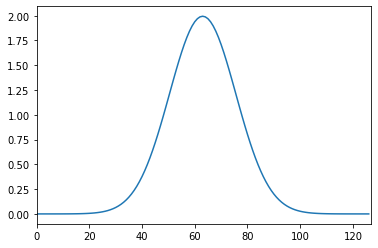

In [8]:
x = np.linspace(-1,1,127)
gauss1D = stats.norm(loc=0.0,scale=0.2).pdf(x)
plt.figure()
plt.plot(gauss1D)
plt.xlim(0,len(gauss1D))
plt.show()

Para gerar a matriz que corresponde a distribuição PDF normal, precisamos primeiramente mapear em cada elemento da matriz  a distância correspondente, para então aplicar a função. A matriz de distâncias foi calculada utilizado a função [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html), em combinação a funções vetoriais que calculam a distância euclidiana.

Uma alternativa seria gerar uma PDF normal unidimensional e aplicar o produto externo para gerar uma matriz de PDF normal. 

(128, 128)


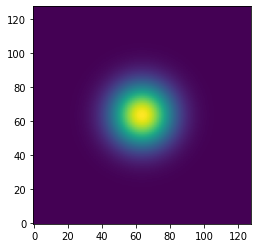

In [17]:
x = np.linspace(-1.0,1.0,128)
dx,dy = np.meshgrid(x,x)
x2D = np.sqrt(dx**2+dy**2)

gauss2D = stats.norm(loc=0.0,scale=0.2).pdf(x2D)

plt.figure()
plt.imshow(gauss2D,origin='lower')
print(gauss2D.shape)
plt.show()

A célula a seguir aplica o algoritmo de GPA nos três primeiros momentos, tanto para a parte simétrica quanto para a parte assimétrica do padrão. 

O valor para a medida relacionada a assimetria deve ser nulo, uma vez que não há vetores assimétricos. Enquanto o primeiro e segundo momento da parte simétrica devem tender a 2, por se tratar de um campo gradiente com padrão regular e alta variabilidade de módulo. O terceiro momento do campo gradiente para a parte simétrica é no entanto a constante 1, pois os vetores estão alinhados ao centro da matriz.

In [18]:
moments = ga(gauss2D, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(gauss2D, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(gauss2D, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(gauss2D, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 0.0, 'G1N': 0.0, 'G2': 0.0, 'G3': 0.0, 'G4': 0j}
Momentos do campo gradiente simétrico: {'G1': 1.985, 'G1N': 0.715, 'G2': 0.966, 'G3': 0.008, 'G4': (2041.2322123348333-6.039613253960852e-14j)}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 1.985, 'G1N': 0.715, 'G2': 1.0, 'G3': 0.008, 'G4': (2041.2322123348333-6.039613253960852e-14j)}
Momentos do campo gradiente completo: {'G1': 1.999, 'G1N': 0.716, 'G2': 1.0, 'G3': 0.004}


A célula a seguir mostra alguns vetores e a classificação do campo vetorial. O ponto central da matriz e a parte externa possuem módulo próximo a zero, dificultando assim a determinação a direção. Sendo assim, esses vetores foram classificados como indeterminados. 

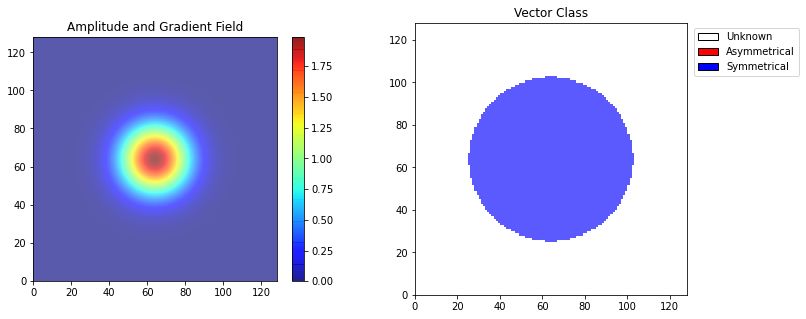

In [19]:
plotGPAVecClass(gauss2D,ga)

# 3. Bessel
-----

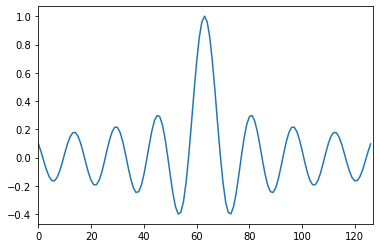

In [20]:
x = np.linspace(-25.0,25.0,127)
besselJ01D = special.j0(x)
plt.figure()
plt.plot(besselJ01D)
plt.xlim(0,len(besselJ01D))
plt.show()

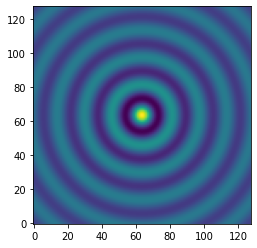

In [22]:
x = np.linspace(-25.0,25.0,128)
dx,dy = np.meshgrid(x,x)
x2D = np.sqrt(dx**2+dy**2)

besselJ02D = special.j0(x2D)

plt.figure()
plt.imshow(besselJ02D,origin='lower')
plt.show()

A célula a seguir aplica o algoritmo de GPA nos três primeiros momentos, tanto para a parte simétrica quanto para a parte assimétrica do padrão. 

O valor para a medida relacionada a assimetria deve ser nulo, uma vez que não há vetores assimétricos.

Diferentemente da PDF normal, os vetores variam de sentido, metade dos vetores simétricos apontam para o centro da matriz e a outra metade aponta para a parte externa da matriz. Sendo assim, $G_3$ é a melhor métrica para distinguir os padrões nesse caso.

In [24]:
moments = ga(besselJ02D, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(besselJ02D, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(besselJ02D, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(besselJ02D, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 0.0, 'G1N': 0.0, 'G2': 0.0, 'G3': 0.0, 'G4': 0j}
Momentos do campo gradiente simétrico: {'G1': 1.997, 'G1N': 0.716, 'G2': 0.987, 'G3': 0.999, 'G4': (3598.7985129866747+1.2789769243681803e-13j)}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 1.997, 'G1N': 0.716, 'G2': 1.0, 'G3': 0.999, 'G4': (3598.7985129866747+1.2789769243681803e-13j)}
Momentos do campo gradiente completo: {'G1': 1.998, 'G1N': 0.716, 'G2': 1.0, 'G3': 0.998}


Novamente o ponto central do padrão possui um vetor indeterminado quanto à simetria, devido a incapacidade de determinar a direção do vetor. No entanto, diferentemente da PDF normal, a função de Bessel possui outros pontos críticos. Vales e cristas possuem também derivada próxima a zero.

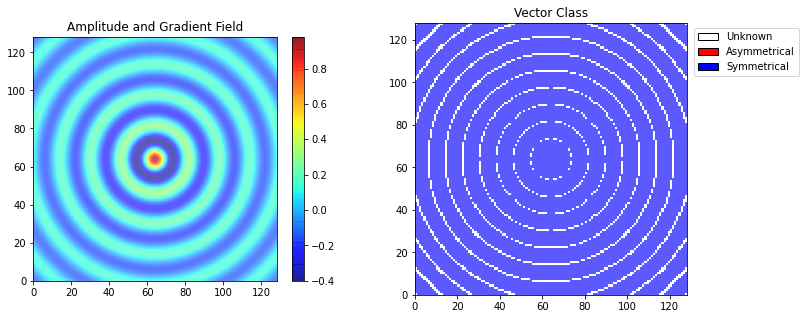

In [25]:
plotGPAVecClass(besselJ02D,ga)

# 4. Ruídos coloridos

In [26]:
white = cn.powerlaw_psd_gaussian(exponent=0.0, size=(128,128))
pink = cn.powerlaw_psd_gaussian(exponent=1.0, size=(128,128))
brown = cn.powerlaw_psd_gaussian(exponent=2.0, size=(128,128))
reddish = cn.powerlaw_psd_gaussian(exponent=5.0, size=(128,128))

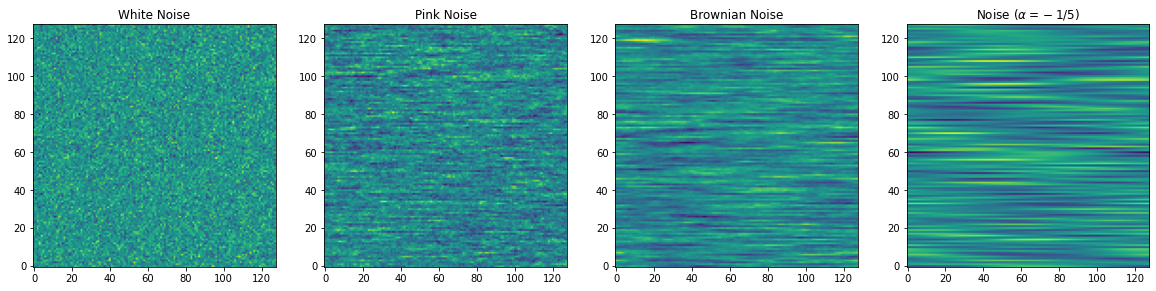

In [27]:
plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.imshow(white,origin='lower')
plt.title("White Noise")

plt.subplot(1,4,2)
plt.imshow(pink,origin='lower')
plt.title("Pink Noise")

plt.subplot(1,4,3)
plt.imshow(brown,origin='lower')
plt.title("Brownian Noise")

plt.subplot(1,4,4)
plt.imshow(reddish,origin='lower')
plt.title(r"Noise ($\alpha = -1/5$)")

plt.show()

In [28]:
moments = ga(white, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(white, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(white, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(white, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 1.991, 'G1N': 0.716, 'G2': 0.138, 'G3': 0.721, 'G4': (695.7465332121462+20.902296397113048j)}
Momentos do campo gradiente simétrico: {'G1': 1.999, 'G1N': 0.716, 'G2': 0.989, 'G3': 0.71, 'G4': (2588.865344860118+61.38262203358302j)}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 1.999, 'G1N': 0.716, 'G2': 1.0, 'G3': 0.712, 'G4': (3284.6118780722636+82.28491843069607j)}
Momentos do campo gradiente completo: {'G1': 1.999, 'G1N': 0.716, 'G2': 0.999, 'G3': 0.712}


In [29]:
moments = ga(pink, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(pink, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(pink, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(pink, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 1.991, 'G1N': 0.716, 'G2': 0.118, 'G3': 0.715, 'G4': (450.51117736904666-15.429628958339098j)}
Momentos do campo gradiente simétrico: {'G1': 1.998, 'G1N': 0.716, 'G2': 0.989, 'G3': 0.707, 'G4': (1954.8701925610949+32.893972853380916j)}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 1.998, 'G1N': 0.716, 'G2': 0.999, 'G3': 0.708, 'G4': (2405.381369930142+17.464343895041814j)}
Momentos do campo gradiente completo: {'G1': 1.999, 'G1N': 0.716, 'G2': 0.999, 'G3': 0.708}


In [30]:
moments = ga(brown, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(brown, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(brown, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(brown, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 1.981, 'G1N': 0.715, 'G2': 0.055, 'G3': 0.709, 'G4': (129.5633856535447-10.48516089157162j)}
Momentos do campo gradiente simétrico: {'G1': 1.998, 'G1N': 0.716, 'G2': 0.985, 'G3': 0.708, 'G4': (807.2513628512568-92.35095055914097j)}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 1.998, 'G1N': 0.716, 'G2': 0.999, 'G3': 0.708, 'G4': (936.8147485048016-102.83611145071258j)}
Momentos do campo gradiente completo: {'G1': 1.998, 'G1N': 0.716, 'G2': 0.999, 'G3': 0.708}


# 5. Ruído de Perlin
----

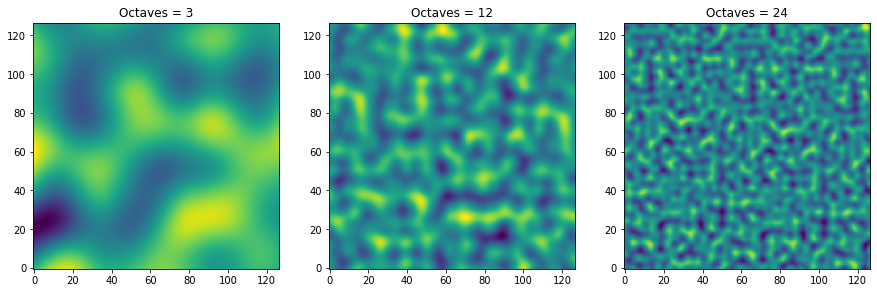

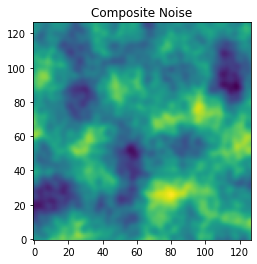

In [31]:
grid = np.linspace(0,1,127)

oct3x3 = PerlinNoise(octaves=3)
n3x3 = np.array([[oct3x3([x,y])  for x in grid] for y in grid])

oct6x6 = PerlinNoise(octaves=6)
n6x6 = np.array([[oct6x6([x,y])  for x in grid] for y in grid])

oct12x12 = PerlinNoise(octaves=12)
n12x12 = np.array([[oct12x12([x,y])  for x in grid] for y in grid])

oct18x18 = PerlinNoise(octaves=18)
n18x18 = np.array([[oct18x18([x,y])  for x in grid] for y in grid])

oct24x24 = PerlinNoise(octaves=24)
n24x24 = np.array([[oct24x24([x,y])  for x in grid] for y in grid])

decay = 5./3.
composite = n3x3/np.log(decay**3)+n6x6/np.log(decay**6)+n12x12/np.log(decay**12)+n18x18/np.log(decay**18)+n24x24/np.log(decay**24)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(n3x3,origin='lower')
plt.title("Octaves = 3")
plt.subplot(1,3,2)
plt.imshow(n12x12,origin='lower')
plt.title("Octaves = 12")
plt.subplot(1,3,3)
plt.imshow(n24x24,origin='lower')
plt.title("Octaves = 24")
plt.show()

plt.figure()
plt.imshow(composite,origin='lower')
plt.title("Composite Noise")
plt.show()

## 5.1. GPA e frequência espacial

O teste a seguir mostra o resultado do GPA para diferentes escalas de ruído, o objetivo é meramente ilustrativo.

In [33]:
moments = ga(n3x3, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(n3x3, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(n3x3, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(n3x3, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 1.992, 'G1N': 0.716, 'G2': 0.432, 'G3': 0.683, 'G4': (2990.4585561065715+1108.170112361184j)}
Momentos do campo gradiente simétrico: {'G1': 1.996, 'G1N': 0.716, 'G2': 0.987, 'G3': 0.715, 'G4': (2723.435187060177+232.72788904874906j)}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 1.998, 'G1N': 0.716, 'G2': 0.968, 'G3': 0.7, 'G4': (5713.893743166749+1340.898001409933j)}
Momentos do campo gradiente completo: {'G1': 1.998, 'G1N': 0.716, 'G2': 0.968, 'G3': 0.7}


In [34]:
moments = ga(n12x12, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(n12x12, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(n12x12, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(n12x12, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 1.994, 'G1N': 0.716, 'G2': 0.365, 'G3': 0.722, 'G4': (2350.7509724107063-7.595861881297438j)}
Momentos do campo gradiente simétrico: {'G1': 1.997, 'G1N': 0.716, 'G2': 0.988, 'G3': 0.703, 'G4': (3082.8483725903397-59.82374041928961j)}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 1.998, 'G1N': 0.716, 'G2': 0.999, 'G3': 0.71, 'G4': (5433.599345001046-67.41960230058702j)}
Momentos do campo gradiente completo: {'G1': 1.998, 'G1N': 0.716, 'G2': 1.0, 'G3': 0.71}


In [35]:
moments = ga(composite, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(composite, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(composite, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(composite, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 1.996, 'G1N': 0.716, 'G2': 0.355, 'G3': 0.713, 'G4': (2435.269494243661+15.682311716694684j)}
Momentos do campo gradiente simétrico: {'G1': 1.998, 'G1N': 0.716, 'G2': 0.987, 'G3': 0.698, 'G4': (2829.0589667229056+163.55092461965623j)}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 1.998, 'G1N': 0.716, 'G2': 0.987, 'G3': 0.704, 'G4': (5264.328460966566+179.23323633635087j)}
Momentos do campo gradiente completo: {'G1': 1.998, 'G1N': 0.716, 'G2': 0.987, 'G3': 0.704}
